In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import json
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [2]:
data_root = "ssl_dataset"
train_dirs = ["train.X1", "train.X2", "train.X3", "train.X4"]
val_dir = "val.X"
label_map_file = "Labels.json"
batch_size = 1024
image_size = 60
epochs = 35
learning_rate = 1.2
projection_dim = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class SimCLRDataset(Dataset):
    def __init__(self, root_dirs, transform):
        self.samples = []
        for rd in root_dirs:
            folder = os.path.join(data_root, rd)
            for class_folder in os.listdir(folder):
                class_path = os.path.join(folder, class_folder)
                for fname in os.listdir(class_path):
                    self.samples.append(os.path.join(class_path, fname))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path = self.samples[idx]
        img = Image.open(path).convert('RGB')
        xi = self.transform(img)
        xj = self.transform(img)
        return xi, xj

In [4]:
contrastive_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1,2.0)),
    transforms.ToTensor(),
])

In [5]:
class SimCLR(nn.Module):
    def __init__(self, base_model='resnet18', out_dim=128):
        super(SimCLR, self).__init__()
        resnet = models.resnet18(pretrained=False)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        self.projector = nn.Sequential(
            nn.Linear(resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        h = self.encoder(x).squeeze()
        z = self.projector(h)
        return z

In [6]:
def nt_xent_loss(z_i, z_j, temperature=0.5):
    N = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)
    z = F.normalize(z, dim=1)

    similarity = torch.matmul(z, z.T)
    mask = torch.eye(2 * N, dtype=torch.bool).to(z.device)
    similarity.masked_fill_(mask, -1e9)

    sim = similarity / temperature

    targets = torch.cat([torch.arange(N) + N, torch.arange(N)], dim=0).to(z.device)
    loss = F.cross_entropy(sim, targets)
    return loss

In [7]:
from torch.optim.optimizer import Optimizer
class LARS(Optimizer):
    def __init__(self, params, lr=0.1, momentum=0.9, weight_decay=1e-6, eta=0.001, eps=1e-8):
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay, eta=eta, eps=eps)
        super(LARS, self).__init__(params, defaults)
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                param = p.data
            
                if group['weight_decay'] != 0:
                    grad = grad + group['weight_decay'] * param
                param_norm = torch.norm(param)
                grad_norm = torch.norm(grad)
                if param_norm > 0 and grad_norm > 0:
                    local_lr = group['eta'] * param_norm / (grad_norm + group['eps'])
                else:
                    local_lr = 1.0  
                actual_lr = local_lr * group['lr']
                state = self.state[p]
                if 'momentum_buffer' not in state:
                    buf = state['momentum_buffer'] = torch.clone(grad).detach()
                else:
                    buf = state['momentum_buffer']
                    buf.mul_(group['momentum']).add_(grad)
                p.data.add_(-actual_lr, buf)


In [9]:
def train():
    dataset = SimCLRDataset(train_dirs, contrastive_transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)

    model = SimCLR(out_dim=projection_dim).to(device)
    optimizer = LARS(model.parameters(), lr=learning_rate)
    scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=epochs)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        print(f"Starting epoch {epoch+1}")
        for i,(xi, xj) in enumerate(loader): 
            xi, xj = xi.to(device), xj.to(device)
            zi = model(xi)
            zj = model(xj)

            loss = nt_xent_loss(zi, zj)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            print(f"Finished batch {i+1}/{len(loader)}") if (i+1)%50==0 else None
        scheduler.step()
        avg_loss = total_loss / len(loader)
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

    torch.save(model.encoder.state_dict(), "simclr_encoder.pth")
    print("Encoder saved.")

In [10]:
#DO NOT RUN AGAIN IF USING WEIGHTS FILE
train()

C:\Users\Shreshth\miniconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Shreshth\miniconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1


C:\Users\Shreshth\AppData\Local\Temp\ipykernel_18072\1629037982.py:29: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\python_arg_parser.cpp:1661.)
  p.data.add_(-actual_lr, buf)


Finished batch 50/127
Finished batch 100/127
Epoch [1/35] Loss: 6.7058
Starting epoch 2
Finished batch 50/127
Finished batch 100/127
Epoch [2/35] Loss: 6.3968
Starting epoch 3
Finished batch 50/127
Finished batch 100/127
Epoch [3/35] Loss: 6.3099
Starting epoch 4
Finished batch 50/127
Finished batch 100/127
Epoch [4/35] Loss: 6.2736
Starting epoch 5
Finished batch 50/127
Finished batch 100/127
Epoch [5/35] Loss: 6.2452
Starting epoch 6
Finished batch 50/127
Finished batch 100/127
Epoch [6/35] Loss: 6.2263
Starting epoch 7
Finished batch 50/127
Finished batch 100/127
Epoch [7/35] Loss: 6.2068
Starting epoch 8
Finished batch 50/127
Finished batch 100/127
Epoch [8/35] Loss: 6.1831
Starting epoch 9
Finished batch 50/127
Finished batch 100/127
Epoch [9/35] Loss: 6.1751
Starting epoch 10
Finished batch 50/127
Finished batch 100/127
Epoch [10/35] Loss: 6.1634
Starting epoch 11
Finished batch 50/127
Finished batch 100/127
Epoch [11/35] Loss: 6.1489
Starting epoch 12
Finished batch 50/127
Finis

In [14]:
def linear_probe():
    class ImageNetDataset(Dataset):
        def __init__(self, root, transform):
            self.samples = []
            self.labels = []
            with open(os.path.join(data_root,label_map_file)) as f:
                original_dict=json.load(f)
            class_names = list(original_dict.keys())
            label_to_index = {name: idx for idx, name in enumerate(class_names)}
            for class_folder in os.listdir(root):
                class_path = os.path.join(root, class_folder)
                label = label_to_index[class_folder]
                for fname in os.listdir(class_path):
                    self.samples.append(os.path.join(class_path, fname))
                    self.labels.append(label)
            self.transform = transform

        def __len__(self):
            return len(self.samples)

        def __getitem__(self, idx):
            img = Image.open(self.samples[idx]).convert('RGB')
            return self.transform(img), self.labels[idx]

    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])

    val_dataset = ImageNetDataset(os.path.join(data_root, val_dir), transform)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    encoder = models.resnet18(pretrained=False)
    encoder = nn.Sequential(*list(encoder.children())[:-1])
    encoder.load_state_dict(torch.load("simclr_encoder.pth"))
    encoder.to(device)
    encoder.eval()

    features, labels = [], []
    with torch.no_grad():
        for i,(x,y) in enumerate(val_loader):
            x = x.to(device)
            h = encoder(x).squeeze()
            features.append(h.cpu())
            labels.extend(y)

    features = torch.cat(features)
    labels = torch.tensor(labels)

    classifier = nn.Linear(features.shape[1], 100)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.1)
    criterion = nn.CrossEntropyLoss()

    acc_list, loss_list,f1_list =[], [], []
    for epoch in range(5000):
        classifier.train()
        total_loss, correct = 0, 0
        all_preds, all_labels = [], []

        for i in range(0, len(features), 64):
            x_batch = features[i:i+64]
            y_batch = labels[i:i+64]

            preds = classifier(x_batch)
            loss = criterion(preds, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (preds.argmax(1) == y_batch).sum().item()

            all_preds.extend(preds.argmax(1).tolist())
            all_labels.extend(y_batch.tolist())
        acc = correct / len(features)
        f1 = f1_score(all_labels, all_preds, average='macro')
    

        acc_list.append(acc)
        loss_list.append(total_loss)
        f1_list.append(f1)
        print(f"Epoch {epoch+1}: Loss={total_loss/len(val_loader):.4f}, Accuracy={acc:.4f}, F1={f1:.4f}") if (epoch+1)%50==0 else None

    plt.plot(acc_list)
    plt.xlabel('Epoch')
    plt.title("Accuracy")
    plt.savefig("SimCLR_accuracy.png")
    plt.show()
    plt.plot(loss_list)
    plt.xlabel('Epoch')
    plt.title("Loss")
    plt.savefig("SimCLR_loss.png")
    plt.show()

C:\Users\Shreshth\miniconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Shreshth\miniconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 50: Loss=154.7835, Accuracy=0.0370, F1=0.0367
Epoch 100: Loss=136.8225, Accuracy=0.0852, F1=0.0842
Epoch 150: Loss=124.2630, Accuracy=0.1146, F1=0.1142
Epoch 200: Loss=111.4233, Accuracy=0.1488, F1=0.1478
Epoch 250: Loss=99.6163, Accuracy=0.1842, F1=0.1829
Epoch 300: Loss=92.9888, Accuracy=0.2126, F1=0.2117
Epoch 350: Loss=81.9625, Accuracy=0.2524, F1=0.2518
Epoch 400: Loss=75.6719, Accuracy=0.2846, F1=0.2823
Epoch 450: Loss=70.6329, Accuracy=0.2866, F1=0.2850
Epoch 500: Loss=62.5324, Accuracy=0.3326, F1=0.3304
Epoch 550: Loss=60.3882, Accuracy=0.3248, F1=0.3216
Epoch 600: Loss=52.5851, Accuracy=0.3872, F1=0.3855
Epoch 650: Loss=47.4211, Accuracy=0.3994, F1=0.3987
Epoch 700: Loss=45.4714, Accuracy=0.4128, F1=0.4101
Epoch 750: Loss=36.5983, Accuracy=0.4766, F1=0.4748
Epoch 800: Loss=36.2852, Accuracy=0.5102, F1=0.5072
Epoch 850: Loss=34.2204, Accuracy=0.4998, F1=0.4974
Epoch 900: Loss=31.9314, Accuracy=0.5252, F1=0.5267
Epoch 950: Loss=29.9218, Accuracy=0.5448, F1=0.5412
Epoch 100

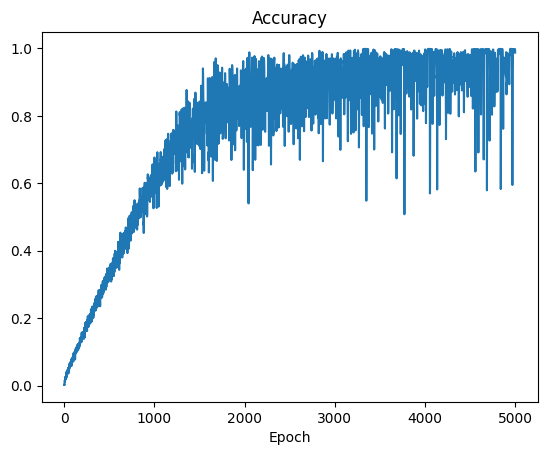

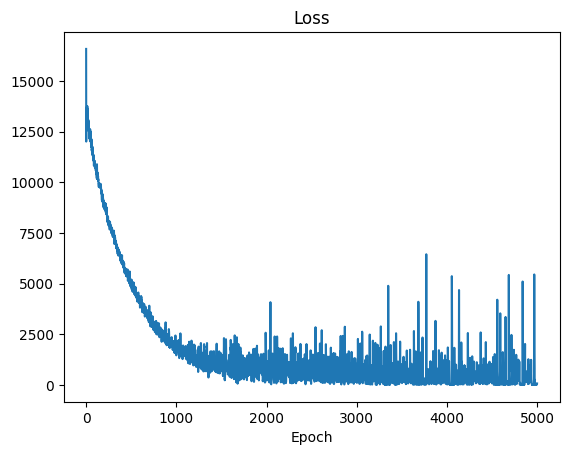

In [15]:
linear_probe()